# Backorder Prediction System

Backorders are one of the major problem in supply chain and logistics. Backorders are products that are temporarily out of stock, however a customer is permitted to place an order against future stock. Back orders are both good and bad: Strong demand can drive back orders, but so can suboptimal planning. The problem is when a product is not immediately available, customers may not have the extravagance or patience to wait. This results in lost sales and low customer satisfaction.

# Problem Definition

Inventory management is a risky business. Too much product on hand increases carrying costs. Too little increases the chance of back order. A review of data done by the FedEx representatives suggest that a single backorder costs the company around \$11 - \$15. For example, an average company processing 1 million orders per year with a 20% backorder rate would experience 200,000 backorders during a year. At cost of \$13.28 per back order, a total increased cost due to backorders is approximately \$2,656,000. Thus, predicting the backorders is an essential task in inventory control planning. Implementing machine learning to complete the task is the best way to go about solving this issue. Using the previous data, we are trying to predict the Backorders to prevent losses for a company.

## Studying the data

We have taken the kaggle dataset for backorder prediction which is a large dataset with over a million SKUs. We further import an study the dataset for better understanding of the correlations and the distributions of various features. 

In [1]:
# Importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC                         
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn import linear_model

In [2]:
# Dictionary containing values for representing NaNs
na_other = {'perf_6_month_avg':-99, 'perf_12_month_avg':-99}

#reading the data
train_data = pd.read_csv("Kaggle_Training_Dataset_v2.csv", na_values = na_other)
test_data = pd.read_csv("Kaggle_Test_Dataset_v2.csv", na_values = na_other)

#The warning is due to the large size of the dataset.

C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_data.head().transpose() #exploring the variables.

,0,1,2,3,4
sku,1026827,1043384,1043696,1043852,1044048
national_inv,0,2,2,7,8
lead_time,NaN,9,NaN,8,NaN
in_transit_qty,0,0,0,0,0
forecast_3_month,0,0,0,0,0
forecast_6_month,0,0,0,0,0
forecast_9_month,0,0,0,0,0
sales_1_month,0,0,0,0,0
sales_3_month,0,0,0,0,0
sales_6_month,0,0,0,0,0


In [4]:
train_data.tail(2).transpose()

,1687859,1687860
sku,1502009,(1687860 rows)
national_inv,19,NaN
lead_time,4,NaN
in_transit_qty,0,NaN
forecast_3_month,0,NaN
forecast_6_month,0,NaN
forecast_9_month,0,NaN
sales_1_month,2,NaN
sales_3_month,7,NaN
sales_6_month,12,NaN


In [5]:
test_data.tail(2).transpose()

,242074,242075
sku,3526991,(242075 rows)
national_inv,2913,NaN
lead_time,12,NaN
in_transit_qty,0,NaN
forecast_3_month,0,NaN
forecast_6_month,0,NaN
forecast_9_month,0,NaN
sales_1_month,0,NaN
sales_3_month,30,NaN
sales_6_month,88,NaN


We see that the last rows of test and train data are null. Thus, we remove the row from our dataset.

In [3]:
# Drop the last row
train_data = train_data[:-1]
test_data = test_data[:-1]

In [7]:
#Summarise the numerical values in training data
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
national_inv,1687860.0,496.111782,29615.233831,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1586967.0,7.872267,7.056024,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1687860.0,44.052022,1342.741731,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1687860.0,178.119284,5026.553102,0.0,0.00,0.00,4.00,1427612.0
forecast_6_month,1687860.0,344.986664,9795.151861,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1687860.0,506.364431,14378.923562,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1687860.0,55.926069,1928.195879,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1687860.0,175.025930,5192.377625,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1687860.0,341.728839,9613.167104,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1687860.0,525.269701,14838.613523,0.0,0.00,4.00,47.00,3205172.0


In [8]:
#summarise non-numerical values in training data
train_data.describe(include = ['O']).transpose()

,count,unique,top,freq
sku,1687860,1687860,3271681,1
potential_issue,1687860,2,No,1686953
deck_risk,1687860,2,No,1300377
oe_constraint,1687860,2,No,1687615
ppap_risk,1687860,2,No,1484026
stop_auto_buy,1687860,2,Yes,1626774
rev_stop,1687860,2,No,1687129
went_on_backorder,1687860,2,No,1676567


## Notes on data above:

* Data is a mix of categorical and numerical values
* The SKU has a unique value for each row, thus it can be considered as an index and ignored
* The categorical values contain "Yes" and "No" which can be converted to "1" and "0"
* The numerical features have different scales, thus we can normalize / standardize them to the same scale
* There are missing values in lead_time, perf_6_month_avg and perf_12_month_avg which will need to be handled
* There are only 0.67% observations where the product went on a backorder, this needs to be balanced well

In [4]:
#Drop SKU column
train_data = train_data.drop('sku', axis = 1)
test_data = test_data.drop('sku', axis = 1)

In [5]:
#change categorical to boolean 

cat_vars = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk','stop_auto_buy', 'rev_stop', 'went_on_backorder']

for var in cat_vars:
    test_data[var] = test_data[var].map({'No':0,'Yes':1})
    train_data[var] = train_data[var].map({'No':0,'Yes':1})

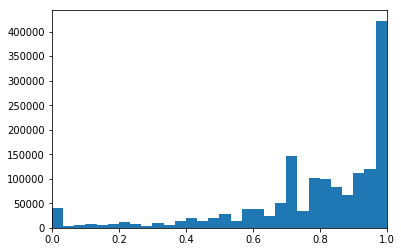

In [11]:
#Looking at the distribution of perf_6_month_avg
x = train_data.perf_6_month_avg.dropna()
plt.hist(x, bins = 30)
plt.xlim(0,1)
plt.show()

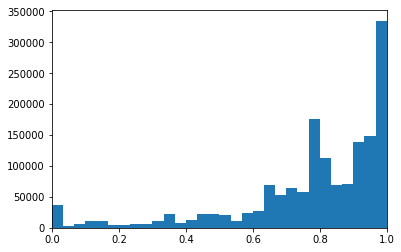

In [12]:
#Looking at the distribution of perf_12_month_avg
x = train_data.perf_12_month_avg.dropna()
plt.hist(x, bins = 30)
plt.xlim(0,1)
plt.show()

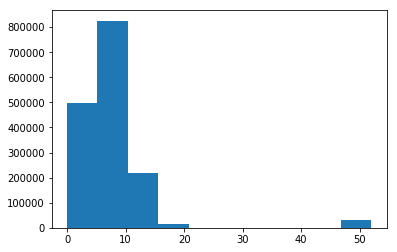

In [13]:
#Looking at the distribution of the lead_time
x = train_data.lead_time.dropna()
plt.hist(x)
plt.show()

### Replacing with median:

observing the plots, we can see that the distribution is either right or left skewed. Thus, replacing the missing values using the mean seems like a better option rather than using the mean.

In [6]:
# Replace NaNs in the dataset

# perf_6_month_avg
train_data.perf_6_month_avg = train_data.perf_6_month_avg.fillna(train_data.perf_6_month_avg.median())
test_data.perf_6_month_avg = test_data.perf_6_month_avg.fillna(test_data.perf_6_month_avg.median())

# perf_12_month_avg
train_data.perf_12_month_avg = train_data.perf_6_month_avg.fillna(train_data.perf_12_month_avg.median())
test_data.perf_12_month_avg = test_data.perf_6_month_avg.fillna(test_data.perf_12_month_avg.median())

# lead_time
train_data.lead_time = train_data.lead_time.fillna(train_data.lead_time.median())
test_data.lead_time = test_data.lead_time.fillna(test_data.lead_time.median())

In [15]:
forecasts = ['forecast_3_month','forecast_6_month', 'forecast_9_month']
sns.pairplot(train_data, hue = 'went_on_backorder', vars = forecasts, size = 3 )

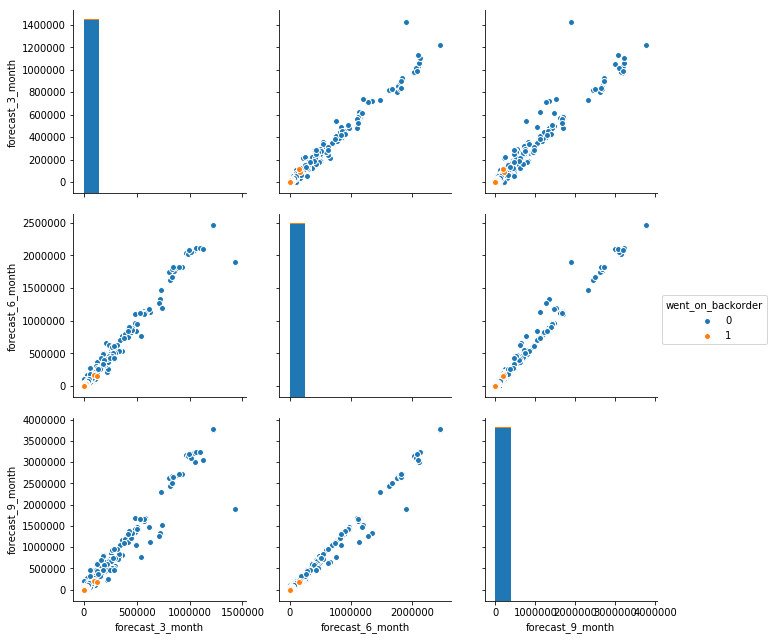

In [17]:
plt.show()

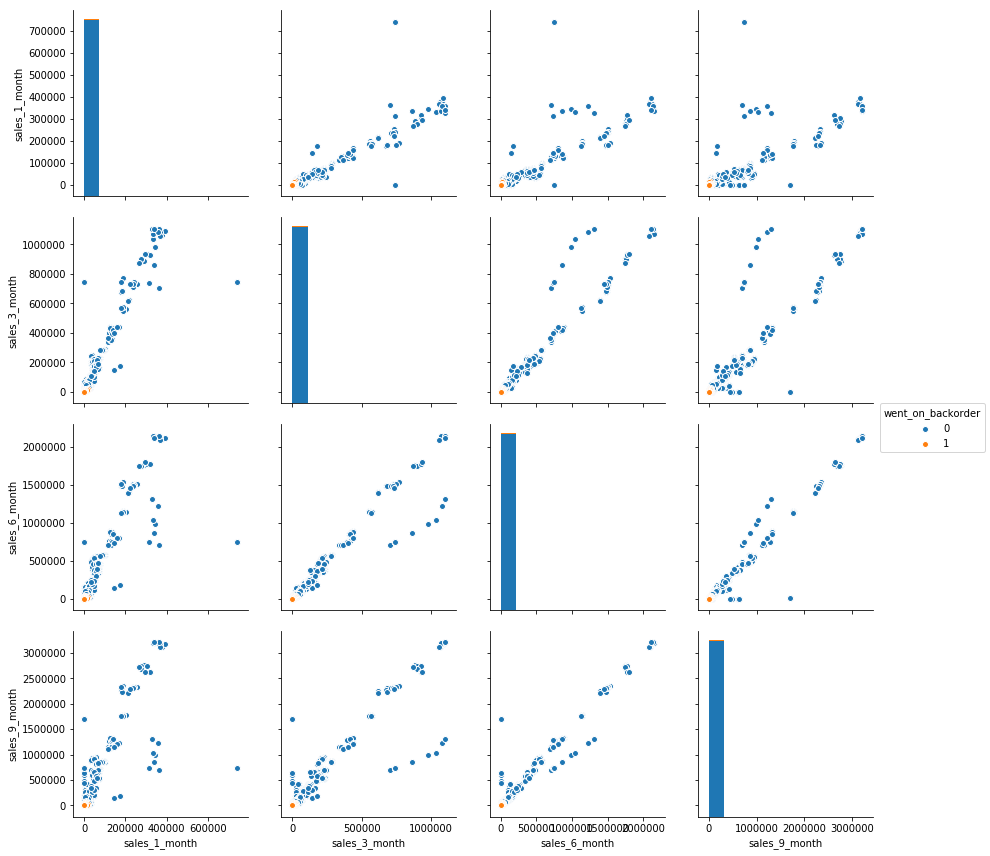

In [18]:
sales = ['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month']
sns.pairplot(train_data, vars=sales, hue='went_on_backorder', size=3)
plt.show()

# Relation between variables:

We see that the relationship between the variables here is linear and they are highly correlated. Also, we observe that the backorders happen only when the value of sales and forecast is very low.

In [7]:
# Separate data by going on backorder or not
no_bo = train_data.loc[train_data['went_on_backorder'] == 0]       
is_bo = train_data.loc[train_data['went_on_backorder'] == 1]

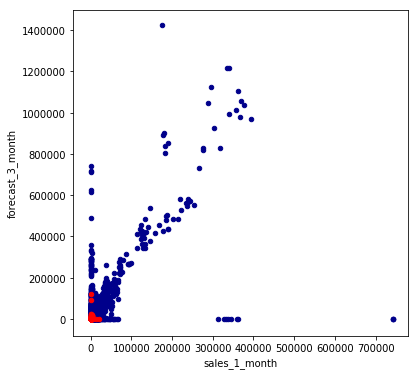

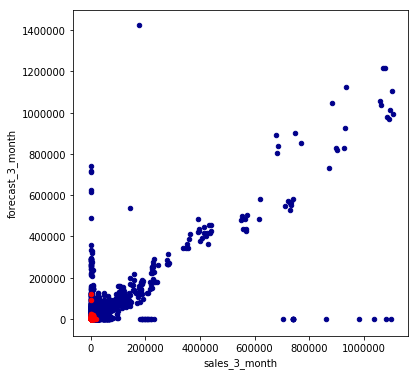

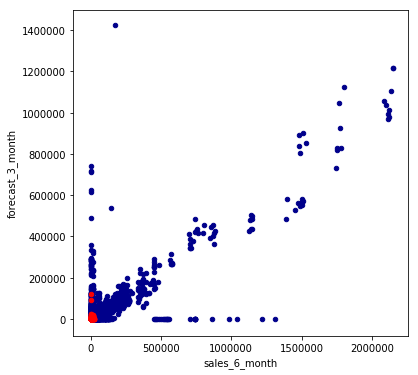

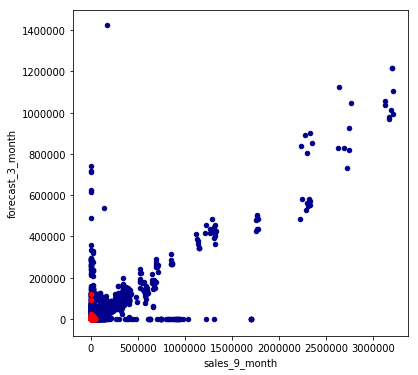

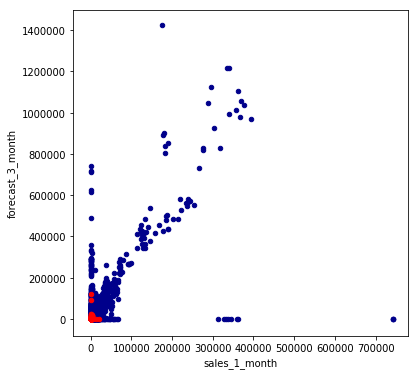

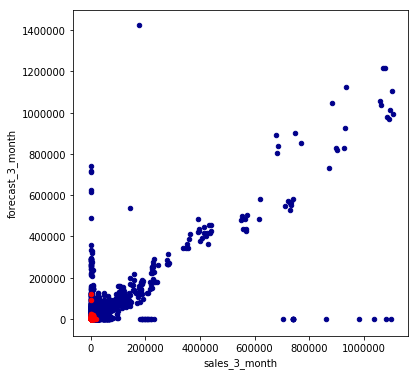

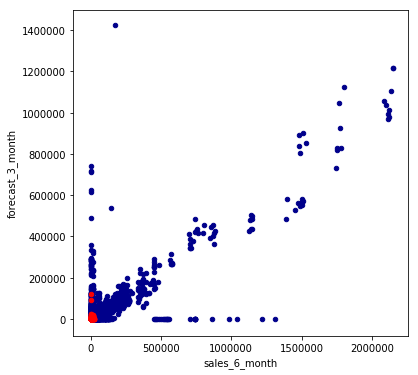

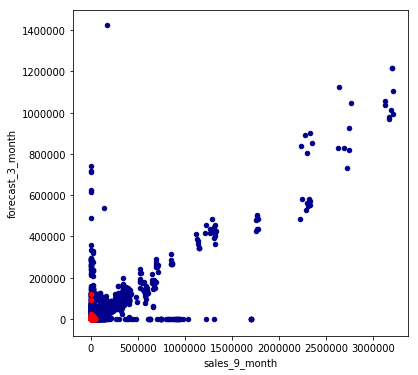

In [22]:
# Make scatter plots of the 3-month forecast against each of the sales
for col in sales:
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    no_bo.plot(kind='scatter', x=col, y='forecast_3_month', ax=ax, color='DarkBlue', legend=True)
    is_bo.plot(kind='scatter', x=col, y='forecast_3_month', ax=ax, color='Red')
    plt.show()

Here we can see that the relation between the forecast and the sales follow a linear pattern and have a relatively high correlation between them

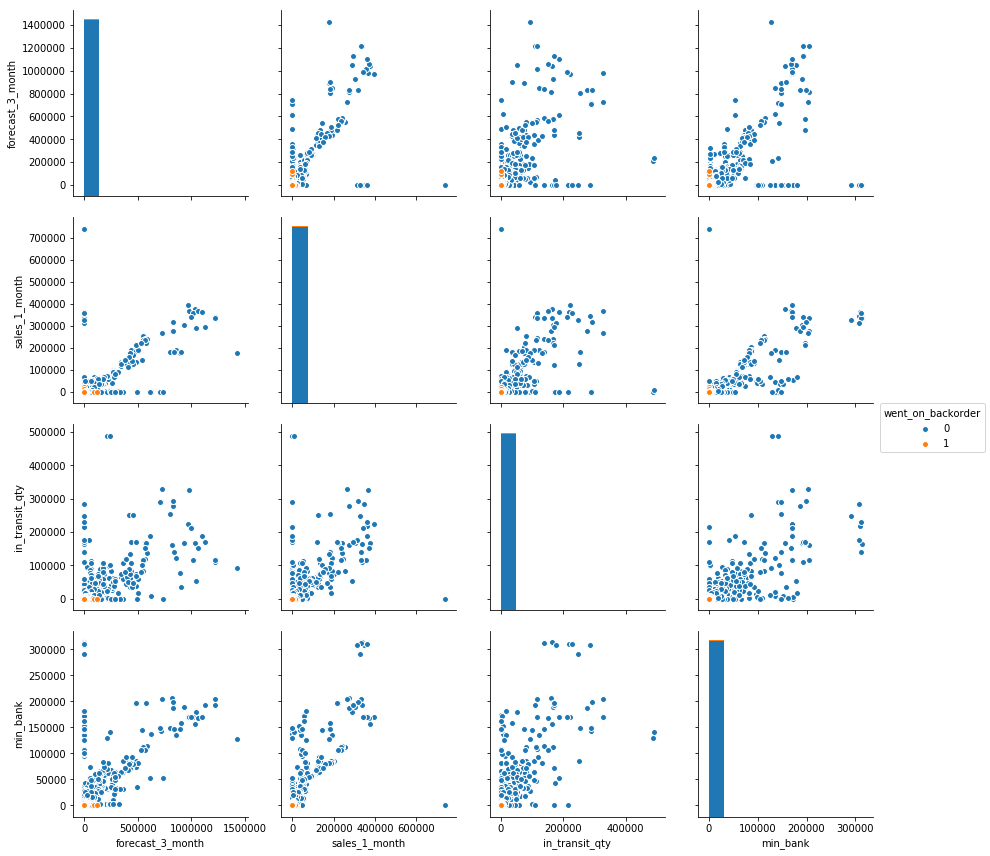

In [25]:
# Look at forecast, sales, in transit and recommended stock level in a pair-wise scatter plot
feature_set_1 = ['forecast_3_month', 'sales_1_month', 'in_transit_qty', 'min_bank']
sns.pairplot(train_data, vars=feature_set_1, hue='went_on_backorder', size=3)
plt.show()

The scatter plots show okay linear relationships between forecast, sales, in transit and recommended stock level. All the features range from 0 to over 300,000. Backorders only occur when the features are at low values.

Due to the good correlations and sufficiently linear relationships between these features, they will all be represented by a single feature in the machine learning models. The feature chosen is sales_1_month. This is because past sales is measured, whereas the quantity in transit, recommended minimum stock and forecasts are likely derived from past sales.

In [8]:
# Filter out the data that will be used

# Features chosen
features = ['national_inv', 'lead_time', 'sales_1_month', 'pieces_past_due', 'perf_6_month_avg',
            'local_bo_qty', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']

train_df = train_data[features]
test_df = test_data[features]

# Set labels
train_label = train_data['went_on_backorder']
test_label = test_data['went_on_backorder']

In [9]:
# Change scale of data

# Use MinMaxScaler to convert features to range 0-1
# The label is already in the range 0-1, so it won't be affected by this.
pp_method = MinMaxScaler()
pp_method.fit(train_df)

reduced_train_df = pp_method.transform(train_df)
reduced_train_df = pd.DataFrame(reduced_train_df, columns=features)

reduced_test_df = pp_method.transform(test_df)
reduced_test_df = pd.DataFrame(reduced_test_df, columns=features)

In [10]:
train_complete = pd.concat([reduced_train_df,train_label], axis = 1)
test_complete = pd.concat([reduced_test_df,test_label], axis = 1)

# Applying various ML models:
* SVM
* Logisitc Regression
* KNN
* Random Forest

While running the models of KNN, Logistic Regression, SVM on data, the runningtime for them were more than 3 hours. Thus, given the time constraint we plan to stick to the Random Forest for our modeling. Random Forest is computationally less expensive and gives a better result as compared to the other algorithams on an unbalanced dataset. The statement is based on a [research](https://elitedatascience.com/imbalanced-classes) article on [Elite Data Science](https://elitedatascience.com/).

# Applying Random Forest:

To observe the effect of undersampling on our results we apply the Random Forest algorithm bothways and then compare the results.We then use the K-fold cross validation to validate our results.


In [11]:
#Merging the train and test data:
total_data = pd.concat([train_complete, test_complete])

In [12]:
# the unbalance in the data:
total_data.went_on_backorder.value_counts()

0    1915954
1      13981
Name: went_on_backorder, dtype: int64

In [13]:
#create a blank dataframe to fill
merged_pred = pd.DataFrame(data=None,index=total_data.index)

#Define folds for  2-fold Cross Validation
kf = KFold(n_splits=2,shuffle=True,random_state=123)  

#Define index of dataset (to help in data sepparations within folds)
ind=total_data.index

In [14]:
#----------fit models and product predictions in each fold----------#

for train_index, test_index in kf.split(total_data):
    
    #Define Training data
    merged_train=total_data[ind.isin(train_index)]
    y_train=merged_train['went_on_backorder']
    X_train=merged_train.drop(['went_on_backorder'],axis=1)

    #Define Test data
    merged_test=total_data[ind.isin(test_index)]
    y_test=merged_test['went_on_backorder']
    X_test=merged_test.drop(['went_on_backorder'],axis=1)
    
    #Define down-sampled training data
    train_majority = merged_train[y_train==0]
    train_minority = merged_train[y_train==1]
    n_minority = len(train_minority)
    train_majority_downsampled = resample(train_majority, 
                                 replace=False,    
                                 n_samples=n_minority,     
                                 random_state=123) 
    train_downsampled = pd.concat([train_majority_downsampled, train_minority])
    y_train_downsampled = train_downsampled['went_on_backorder']
    X_train_downsampled = train_downsampled.drop(['went_on_backorder'],axis=1)
    
    
    #---------------------------------------------------------------#
    #Function to fit models
    def fitrandomforests(n_est,maxfeat,minleaf):
        
        #names of model predictions based on tuning parameter inputs
        varname= "pred_nest%s_feat%s_leaf%s" % (n_est,maxfeat,minleaf)
        varname2= "pred_down_nest%s_feat%s_leaf%s" % (n_est,maxfeat,minleaf)
        
        #Fit a Random Forest model
        rf=RandomForestClassifier(n_estimators=n_est,
                                  max_features=maxfeat,
                                  min_samples_leaf=minleaf)
        rf.fit(X_train,y_train)
        preds=rf.predict_proba(X_test)[:,1]
        merged_test[varname]=preds
        
        #Fit a Random Forest model on downsampled data
        rfd=RandomForestClassifier(n_estimators=n_est,
                                   max_features=maxfeat,
                                   min_samples_leaf=minleaf)
        rfd.fit(X_train_downsampled,y_train_downsampled)
        predsd=rfd.predict_proba(X_test)[:,1]
        merged_test[varname2]=predsd
    #---------------------------------------------------------------#
    
    #Tuning parameter grids
    
    #number of trees (more is better for prediction but slower)
    n_est=50
    #maximum features tried
    maxfeatgrid=[3,5,7]
    #Minimum samples per leaf
    minleafgrid=[5,10,30]
    

    #fit models
    for feat in maxfeatgrid:
        for leaf in minleafgrid:
            fitrandomforests(n_est,feat,leaf)

    #Combine predictions for this fold with previous folds
    merged_pred = pd.concat([merged_pred,merged_test])



#drop NA's from dataframe caused by the method for combining datasets from each loop iteration
merged_pred=merged_pred.dropna()  

C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [15]:
#View AUC for each model and each tuning parameter specification
for feat in maxfeatgrid:
    for leaf in minleafgrid:
        #Random forest for given tuning parameters
        varname1="pred_nest50_feat%s_leaf%s" % (feat,leaf)
        rocscore1=roc_auc_score(merged_pred['went_on_backorder'],merged_pred[varname1])
        print( round(rocscore1,4 ) , varname1 )
        #Down Sampled Random Forest for given tuning parameters
        varname2="pred_down_nest50_feat%s_leaf%s" % (feat,leaf)
        rocscore2=roc_auc_score(merged_pred['went_on_backorder'],merged_pred[varname2])
        print( round(rocscore2,4) , varname2 )

0.8665 pred_nest50_feat3_leaf5
0.8955 pred_down_nest50_feat3_leaf5
0.8577 pred_nest50_feat3_leaf10
0.8856 pred_down_nest50_feat3_leaf10
0.843 pred_nest50_feat3_leaf30
0.8633 pred_down_nest50_feat3_leaf30
0.8763 pred_nest50_feat5_leaf5
0.9051 pred_down_nest50_feat5_leaf5
0.8714 pred_nest50_feat5_leaf10
0.8954 pred_down_nest50_feat5_leaf10
0.8621 pred_nest50_feat5_leaf30
0.874 pred_down_nest50_feat5_leaf30
0.8746 pred_nest50_feat7_leaf5
0.9089 pred_down_nest50_feat7_leaf5
0.8742 pred_nest50_feat7_leaf10
0.9008 pred_down_nest50_feat7_leaf10
0.8685 pred_nest50_feat7_leaf30
0.8777 pred_down_nest50_feat7_leaf30


In [16]:
#ROC Curves for top performing models

#Define false positive rates/true positive rates / thresholds 
#Best random forest model
fpr, tpr, thresholds = roc_curve(merged_pred['went_on_backorder'],
                                 merged_pred['pred_nest50_feat3_leaf5'])

#Best down sampled random forest model
fpr2, tpr2, thresholds2 = roc_curve(merged_pred['went_on_backorder'],
                                    merged_pred['pred_down_nest50_feat7_leaf5'])

#AUC for best Random Forest and Random Forest Down sampled Models
roc_auc = roc_auc_score(merged_pred['went_on_backorder'],
                      merged_pred['pred_nest50_feat3_leaf5'])
roc_auc2 = roc_auc_score(merged_pred['went_on_backorder'],
                      merged_pred['pred_down_nest50_feat7_leaf5'])

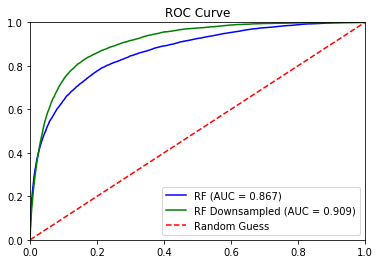

In [17]:
#plot ROC Curve
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='RF (AUC = %0.3f)'% roc_auc)
plt.plot(fpr2, tpr2, 'g', label='RF Downsampled (AUC = %0.3f)'% roc_auc2)
plt.plot([0,1],[0,1],'r--', label='Random Guess')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

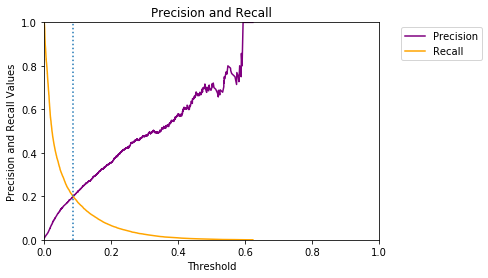

In [65]:
#define precision, recall, and corresponding threshold for model with highest AUC
precision, recall, threshold = precision_recall_curve(merged_pred['went_on_backorder'],
                                                      merged_pred['pred_nest50_feat3_leaf5'])

#plot Precision and Recall for a given threshold.
plt.title('Precision and Recall')
plt.plot(threshold,precision[1:],'purple',label='Precision')
plt.plot(threshold,recall[1:],'orange', label='Recall')
plt.axvline(x=.085,linestyle=":")
plt.legend(loc=2,bbox_to_anchor=(1.05, 1))
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision and Recall Values')
plt.xlabel('Threshold')
plt.show()

In [71]:
#Confusion Matrix 
merged_pred['optimal_classification']=merged_pred['pred_nest50_feat3_leaf5']>.4
pd.crosstab(merged_pred['went_on_backorder'],
            merged_pred['optimal_classification'],
            rownames=['Went on Backorder'],
            colnames=['Predicted going on Backorder?'])

Predicted going on Backorder?,False,True
Went on Backorder,,
0.0,1915860,94
1.0,13854,127


In [68]:
#Accuracy of model
accuracy_score(merged_pred['went_on_backorder'],merged_pred['optimal_classification'])

0.9881964936642944

In [69]:
#Accuracy of "naive" (never-predict-backorder) model
merged_pred['naive_estimator']=0
accuracy_score(merged_pred['went_on_backorder'],merged_pred['naive_estimator'])

0.992755714570698

In [32]:
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split

In [34]:
x = total_data.drop(['went_on_backorder'],axis=1)
y = total_data['went_on_backorder']

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = 123)

In [36]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

C:\Users\amar\Anaconda3\envs\py35\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [74]:
rfd=RandomForestClassifier(n_estimators=50,
                                max_features=5,
                                min_samples_leaf=5)
rfd.fit(x_train_res, y_train_res)
pred = rfd.predict_proba(x_val)[:,1]

In [75]:
fpr, tpr, thresholds = roc_curve(y_val, pred)
#AUC for best Random Forest and Random Forest Down sampled Models
roc_auc = roc_auc_score(y_val,pred)

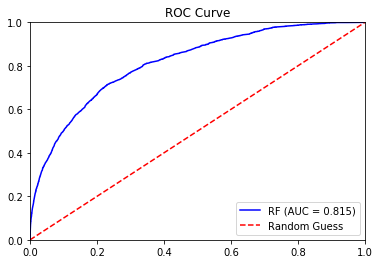

In [77]:
#plot ROC Curve
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='RF (AUC = %0.3f)'% roc_auc)
plt.plot([0,1],[0,1],'r--', label='Random Guess')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

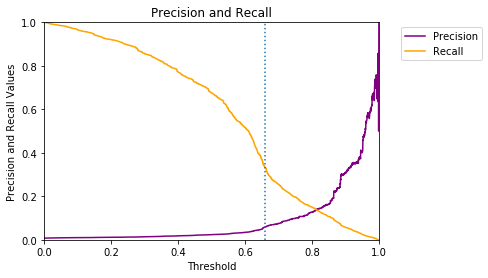

In [102]:
#define precision, recall, and corresponding threshold for model with highest AUC
precision, recall, threshold = precision_recall_curve(y_val,pred)

#plot Precision and Recall for a given threshold.
plt.title('Precision and Recall')
plt.plot(threshold,precision[1:],'purple',label='Precision')
plt.plot(threshold,recall[1:],'orange', label='Recall')
plt.axvline(x=.66,linestyle=":")
plt.legend(loc=2,bbox_to_anchor=(1.05, 1))
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision and Recall Values')
plt.xlabel('Threshold')
plt.show()

In [103]:
#Confusion Matrix 
pd.crosstab(y_val,
            pred>0.66,
            rownames=['Went on Backorder'],
            colnames=['Predicted going on Backorder?'])

Predicted going on Backorder?,False,True
Went on Backorder,,
0,552465,22315
1,2804,1397


In [104]:
#Accuracy of model
accuracy_score(y_val,pred>0.66)

0.9566151566286286